In [1]:
import sys
sys.path.append('/kaggle/input/latex-libraries-1/')

In [2]:
from model import *
from data_iterator import create_data_iterator
import latex_generator as gen
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
latex_gen = gen.ExpressionGenerator(20)

In [6]:
PAD_IDX = latex_gen.token2id['<pad>']

In [7]:
vocab_size = len(latex_gen.tokens)

In [28]:
input_size = (1, 1, 200, 1000)
EMBEDDING_SIZE = 64
img = torch.rand(input_size)
cnn = CNN()
with torch.no_grad():
    output = cnn(img)
_, D, H, W = output.shape
enc = Encoder(D, H, W)

dec = Decoder(emb_size=EMBEDDING_SIZE,
              lstm_hidden_size=256, 
              att_hidden_size=128, 
              o_hidden_size=128,  
              memory_size=256, 
              output_size=vocab_size)

emb = Embedding(input_size=vocab_size, embedded_size=EMBEDDING_SIZE, padding_idx=latex_gen.token2id['<pad>'])

In [9]:
root = '/kaggle/input/latex-project'

In [10]:
BATCH_SIZE = 16

In [11]:
train_iterator = create_data_iterator(root, is_train=True, batch_size=BATCH_SIZE)
test_iterator = create_data_iterator(root, is_train=False, batch_size=BATCH_SIZE)

In [12]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show() 

In [19]:
def train(epoch, dataloader, model, criterion, optimizer, clip):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(X, y)
        output = output[:, 1:, :].contiguous().view(-1, output.shape[-1])
        y = y[:, 1:].contiguous().view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)

In [25]:
def test(epoch, dataloader, model, criterion):
    model.eval()
    num_batches = len(dataloader)
    
    test_loss, correct = 0, 0
    correct_size = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            output = model(X, y, 0)
            output = output[:, 1:, :].contiguous().view(-1, output.shape[-1])
            y = y[:, 1:].contiguous().view(-1)
            loss = criterion(output, y)
            
            mask = (y != PAD_IDX)
            preds = output.argmax(dim=1)
            
            correct += ((y == preds) * mask).sum().item()
            correct_size += mask.sum().item()
            
            test_loss += loss.item()
               
    test_loss /= num_batches
    correct /= correct_size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    show_progress(epoch+1)

In [29]:
model = Model(cnn, enc, emb, dec).to(DEVICE)
criterion = criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
clip = 1

In [30]:
print('Total params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

Total params:  2537984


In [31]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Model(
  (cnn): CNN(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): ReLU()
      (15): MaxPool

In [ ]:
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

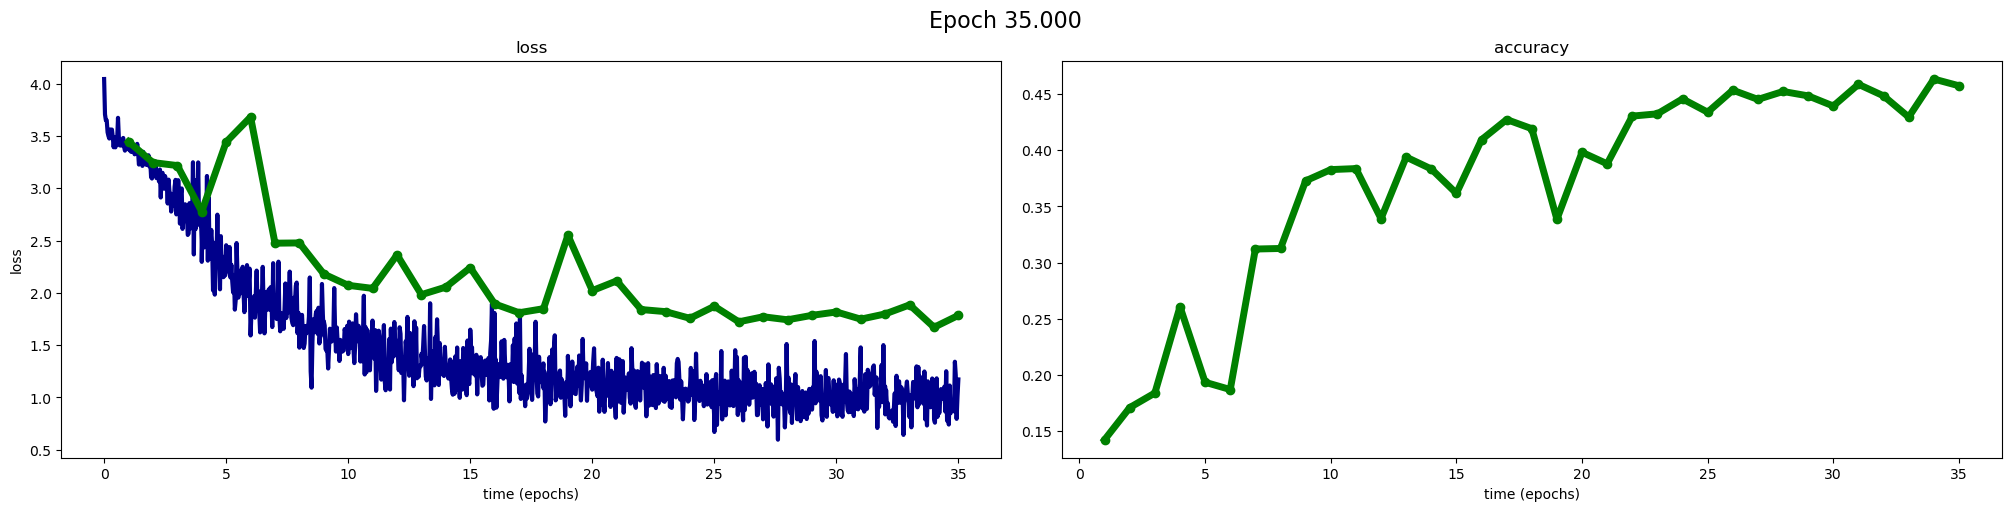

100%|██████████| 5/5 [28:01<00:00, 336.33s/it]


In [51]:
interval = 100

epochs = 30

best_valid_loss = float('inf')

for t in trange(epochs, epochs+5):
    train(t, train_iterator, model, criterion, optimizer, clip)
    test(t, test_iterator, model, criterion)
    
    if val_loss[-1] < best_valid_loss:
        best_valid_loss = val_loss[-1]
        torch.save(model.state_dict(), f'model_{t+1}.pt')

725